# (NO BASELINE) MC simulations using R feature selection 


In [1]:
import os
from sys import stdout

import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import scipy.io
from sklearn import model_selection
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.model_selection import learning_curve

from deap import base
from deap import creator
from deap import tools

from feature_selection import *
from utils import *


import warnings
warnings.filterwarnings('ignore')

# Data loading

In [2]:
#x_df = pd.read_csv('./slag_basic_noBaseline.csv', sep = ',')
#x_df = pd.read_csv('./slag_snv_noBaseline.csv', sep = ',')
x_df = pd.read_csv('./slag_sum_noBaseline.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(34, 3648)
(3648,)
34


,216.330000,216.370000,216.410000,216.450000,216.490000,216.520000,216.560000,216.600000,216.640000,216.680000,...,340.120000,340.150000,340.170000,340.200000,340.230000,340.260000,340.290000,340.320000,340.340000,340.370000
0,0.000010,0.000009,0.000009,0.000009,0.000010,0.000009,0.000010,0.000010,0.000011,0.000012,...,0.000069,0.000074,0.000074,0.000074,0.000074,0.000072,0.000071,0.000072,0.000073,0.000075
1,0.000010,0.000009,0.000009,0.000009,0.000009,0.000009,0.000010,0.000010,0.000011,0.000012,...,0.000070,0.000076,0.000076,0.000077,0.000076,0.000073,0.000073,0.000074,0.000076,0.000077
2,0.000010,0.000008,0.000009,0.000009,0.000009,0.000009,0.000010,0.000010,0.000012,0.000013,...,0.000075,0.000080,0.000080,0.000081,0.000080,0.000078,0.000078,0.000079,0.000080,0.000081
3,0.000010,0.000009,0.000009,0.000010,0.000010,0.000010,0.000010,0.000010,0.000012,0.000014,...,0.000070,0.000075,0.000076,0.000079,0.000078,0.000075,0.000073,0.000075,0.000077,0.000080
4,0.000010,0.000009,0.000009,0.000009,0.000010,0.000010,0.000010,0.000010,0.000012,0.000013,...,0.000069,0.000074,0.000075,0.000076,0.000075,0.000072,0.000071,0.000073,0.000074,0.000077
5,0.000010,0.000009,0.000009,0.000009,0.000010,0.000010,0.000010,0.000010,0.000011,0.000013,...,0.000077,0.000082,0.000082,0.000084,0.000082,0.000080,0.000079,0.000080,0.000082,0.000084
6,0.000010,0.000008,0.000009,0.000009,0.000009,0.000009,0.000010,0.000010,0.000011,0.000013,...,0.000074,0.000079,0.000080,0.000081,0.000080,0.000078,0.000077,0.000078,0.000080,0.000082
7,0.000010,0.000009,0.000009,0.000009,0.000010,0.000009,0.000010,0.000010,0.000011,0.000013,...,0.000076,0.000081,0.000081,0.000083,0.000081,0.000079,0.000078,0.000079,0.000081,0.000083
8,0.000011,0.000010,0.000010,0.000010,0.000011,0.000011,0.000011,0.000011,0.000013,0.000014,...,0.000071,0.000076,0.000077,0.000079,0.000078,0.000075,0.000075,0.000076,0.000078,0.000080
9,0.000009,0.000008,0.000008,0.000008,0.000008,0.000009,0.000009,0.000009,0.000010,0.000012,...,0.000064,0.000069,0.000069,0.000070,0.000069,0.000067,0.000067,0.000068,0.000069,0.000071


[[216.33 216.37 216.41 ... 340.32 340.34 340.37]]
wl shape:  (3648, 1)


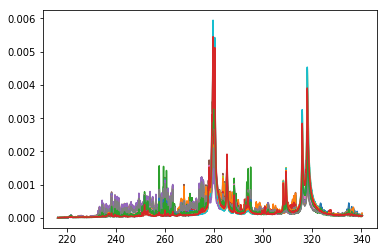

In [3]:
#This is just for visualizing the various plots of the samples
mat = scipy.io.loadmat("./data/H01.mat")
wl= mat["wl"]
print(wl.T)
print("wl shape: ", wl.shape)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show()

In [4]:
print(wl[0])
print(wl[-1])

[216.33]
[340.37]


In [5]:
df_y = pd.read_csv('./slag_concentration.csv')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,2:10])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(34, 11)


,Sample,MgO,Al2O3,SiO2,FeO,MnO,Cr2O3,P2O5,V2O5,TiO2,Ca tot
0,H01,25.00,9.61,13.20,18.30,1.99,0.20,0.23,0.18,1.03,37.98
1,H02,18.00,5.04,14.20,18.90,2.10,0.28,0.26,0.06,1.07,44.72
2,H03,21.10,6.14,10.60,20.20,5.82,0.61,0.40,0.14,0.86,38.72
3,H04,15.50,4.07,12.80,26.70,3.35,0.52,0.31,0.08,1.07,38.44
4,H05,17.10,4.14,14.80,21.70,1.72,0.20,0.29,0.18,1.07,43.38
5,H06,15.90,4.34,16.50,18.90,1.29,0.10,0.30,0.11,1.10,45.53
6,H07,14.30,4.12,16.20,19.00,1.21,0.09,0.27,0.06,1.08,46.35
7,H08,13.00,4.05,16.10,21.00,1.26,0.10,0.28,0.06,1.09,45.29
8,H09,10.60,7.30,14.30,33.20,2.75,0.42,0.32,0.09,1.12,32.81
9,H10,19.30,6.50,14.70,17.40,2.72,0.31,0.28,0.09,1.06,42.64


In [6]:
y_val = concentration[:,2] # 1-Mg, 2-Al, 3-Si, 4-Fe, 5-Mn, 6-Cr, 10-Ca
#print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
y_df.T

(34,)


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,9.61,5.04,6.14,4.07,4.14,4.34,4.12,4.05,7.3,6.5,...,6.7,5.72,9.52,8.57,26.9,25.5,6.05,28.4,6.79,22.1


### wavelenght selection import

In [7]:
sel= pd.read_csv('./selected_wavelengths/selecta_noBaseline_Al_ipls500_sum.txt', sep= ' |,|\n', header = None)
#sel= sel.dropna()
#print(sel, "\n")
sel= sel.values.flatten()
sel= sel[~np.isnan(sel)]
sel = [int(i)-1 for i in sel]
print("number of selected wavelengths: ", len(sel))
#print(sel)

number of selected wavelengths:  21


In [8]:
sel=sel[:-1]
#print(wl.shape)
wl_sel= wl[sel]
print(wl_sel.shape)
wl_sel.T

(20, 1)


array([[237.23, 237.27, 237.3 , 237.34, 237.38, 237.42, 237.45, 301.25,
        301.28, 301.31, 301.35, 301.38, 301.41, 301.45, 337.6 , 337.63,
        337.66, 337.68, 337.71, 337.74]])

In [9]:
#target = [251.59, 288.12, 390.60] #peaks for Si
target = [277.91, 279.59, 280.23, 281.78, 285.27, 383.74] #peaks for Mg
#target = [292.83, 293.61, 294.91, 403.25, 404.63, 404.56] #peaks for Mn
#target= [296.06,324.73, 327.37] #peaks for Cu
#target= [202.60, 206.20, 213.90, 330.14, 334.41] #peaks for Zn
#target= [310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04] #Fe#
#target = [251.59, 288.12, 390.60, 277.91, 279.59, 280.23, 281.78, 383.74, 285.27, 292.83, 293.61, 294.91, 403.25, 404.63, 404.56, 296.06,324.73, 327.37, 330.14, 334.41, 310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04]
#len(target)

In [10]:
a = []
b = []
for t in target:
    for i in range(len(wl_sel)):
        if abs(wl_sel[i][0]-t) <= 0.2:
            a.append(wl_sel[i][0])
            b.append(i)
            
print("number of selected peaks: ",len(a), "\n")
print(a, "\n")
#print(b)

number of selected peaks:  0 

[] 



For Silicon (Si) the peaks are at **251.59, 288.12, 390.60**

For Magnesium (Mg) the peaks are at **277.91, 279.59, 280.23, 281.78, 383.74, 285.27**

For Manganese (Mn) the peaks are at **292.83, 293.61, 294.91, 403.25, 404.63, 404.56**

For Copper (Cu) the peaks are at **296.06,324.73, 327.37**

For Zinc (Zn) the peaks are at **202.55, 206.20, 213.90, 330.14, 334.41**

In [11]:
x_selecta = pd.DataFrame(x_df.values[:,sel])
#x_selecta = pd.DataFrame(x_df.values[:,b])
x_selecta

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000189,0.000190,0.000202,0.000219,0.000260,0.000288,0.000262,0.000135,0.000130,0.000131,0.000129,0.000131,0.000129,0.000135,0.000080,0.000082,0.000083,0.000086,0.000087,0.000091
1,0.000193,0.000195,0.000210,0.000229,0.000276,0.000310,0.000283,0.000133,0.000128,0.000129,0.000127,0.000130,0.000128,0.000135,0.000076,0.000078,0.000078,0.000081,0.000082,0.000085
2,0.000171,0.000174,0.000186,0.000206,0.000249,0.000276,0.000248,0.000139,0.000134,0.000135,0.000135,0.000139,0.000139,0.000148,0.000083,0.000085,0.000086,0.000088,0.000089,0.000092
3,0.000232,0.000236,0.000253,0.000277,0.000329,0.000366,0.000336,0.000129,0.000123,0.000123,0.000121,0.000124,0.000125,0.000131,0.000069,0.000070,0.000071,0.000074,0.000075,0.000079
4,0.000207,0.000210,0.000226,0.000247,0.000298,0.000335,0.000307,0.000131,0.000126,0.000126,0.000125,0.000127,0.000125,0.000130,0.000073,0.000075,0.000076,0.000078,0.000080,0.000084
5,0.000198,0.000201,0.000216,0.000236,0.000286,0.000322,0.000293,0.000134,0.000128,0.000128,0.000126,0.000128,0.000125,0.000130,0.000085,0.000087,0.000087,0.000090,0.000091,0.000095
6,0.000210,0.000213,0.000228,0.000249,0.000298,0.000334,0.000306,0.000138,0.000133,0.000133,0.000131,0.000132,0.000130,0.000134,0.000078,0.000080,0.000081,0.000083,0.000084,0.000088
7,0.000210,0.000213,0.000228,0.000249,0.000298,0.000335,0.000308,0.000137,0.000132,0.000132,0.000130,0.000131,0.000129,0.000133,0.000081,0.000082,0.000083,0.000086,0.000086,0.000090
8,0.000254,0.000258,0.000273,0.000293,0.000338,0.000371,0.000347,0.000131,0.000126,0.000126,0.000124,0.000126,0.000125,0.000131,0.000073,0.000075,0.000076,0.000079,0.000081,0.000084
9,0.000181,0.000184,0.000199,0.000220,0.000269,0.000303,0.000273,0.000127,0.000123,0.000124,0.000122,0.000125,0.000124,0.000131,0.000070,0.000072,0.000072,0.000075,0.000076,0.000080


## Partial Least Squares

In [19]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
#for i in range(100,116):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    #cross validation to find optimal number of components
    plscomp = optimise_pls_cv(X_train, y_train, min(30, X_train.shape[1]), plot_components=False) 

    #PLS model
    #pls =  PLSRegression(n_components=max(6,plscomp), scale=True)
    #pls =  PLSRegression(n_components=max(6, plscomp), scale=False)
    
    pls =  PLSRegression(n_components=plscomp, scale=True)
    #pls =  PLSRegression(n_components=plscomp, scale=False)

    # Fit
    pls.fit(X_train, y_train)

    y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
    y_pred = pls.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)
    
print("FINAL ESTIMATIONS:")   
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
100% completed
Suggested number of components:  13

seed:  2
100% completed
Suggested number of components:  13

seed:  3
100% completed
Suggested number of components:  14

seed:  4
100% completed
Suggested number of components:  18

seed:  5
100% completed
Suggested number of components:  15

seed:  6
100% completed
Suggested number of components:  18

seed:  7
100% completed
Suggested number of components:  19

seed:  8
100% completed
Suggested number of components:  11

seed:  9
100% completed
Suggested number of components:  13

seed:  10
100% completed
Suggested number of components:  17

seed:  11
100% completed
Suggested number of components:  13

seed:  12
100% completed
Suggested number of components:  17

seed:  13
100% completed
Suggested number of components:  12

seed:  14
100% completed
Suggested number of components:  17

seed:  15
100% completed
Suggested number of components:  15

FINAL ESTIMATIONS:
R^2:
mean:  0.044966280242465385
std dev:  1.214397694110017

## Simple Linear Model

In [13]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    
    lm = linear_model.LinearRegression()

    model = lm.fit(X_train, y_train)

    predictions = lm.predict(X_test)
    y_cv = cross_val_predict(lm, X_train, y_train, cv=10)

    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, predictions)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, predictions))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))

print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15

FINAL ESTIMATIONS:
R^2:
mean:  0.21939557027520268
std dev:  0.9091258540631079

rmse:
mean:  1.6467717617796613
std dev:  0.44202057068745865

0.21939557027520268
0.9091258540631079

1.6467717617796613
0.44202057068745865


## Elastic Net

In [14]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    alphas = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

    mses = []

    for a in alphas:
        model = ElasticNet(alpha=a).fit(X_train,y_train)   

        y_cv = cross_val_predict(model, X_train, y_train, cv=10)
        mse = mean_squared_error(y_train, y_cv)
        score = model.score(X_train, y_train)
        #pred_y = model.predict(X_test)
        #mse = mean_squared_error(y_test, pred_y)
        mses.append(mse)
        #print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))
        
    best_index =np.argmin(mses)
    print("best alpha: ", alphas[best_index], "\n")
    
    model = ElasticNet(alpha=alphas[best_index]).fit(X_train,y_train)   

    y_cv = cross_val_predict(model, X_train, y_train, cv=10)
    y_pred = model.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))

print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
best alpha:  0 

seed:  2
best alpha:  0 

seed:  3
best alpha:  0 

seed:  4
best alpha:  0 

seed:  5
best alpha:  0 

seed:  6
best alpha:  0 

seed:  7
best alpha:  0 

seed:  8
best alpha:  0 

seed:  9
best alpha:  0 

seed:  10
best alpha:  0 

seed:  11
best alpha:  0 

seed:  12
best alpha:  0 

seed:  13
best alpha:  0 

seed:  14
best alpha:  0 

seed:  15
best alpha:  0 

FINAL ESTIMATIONS:
R^2:
mean:  -0.9128353946600283
std dev:  2.032964030847279

rmse:
mean:  2.8088574795716563
std dev:  0.46777243942752395

-0.9128353946600283
2.032964030847279

2.8088574795716563
0.46777243942752395


## Random Forest

In [15]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(7,)
(27,)


In [16]:
## R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    
    rf = RandomForestRegressor(n_estimators = 1000, max_depth=30, random_state = seed)
    # Train the model on training data

    rf.fit(X_train, y_train);

    # Use the forest's predict method on the test data
    #y_cv = cross_val_predict(rf, X_train, y_train, cv=10)
    predictions = rf.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, predictions)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, predictions))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15

FINAL ESTIMATIONS:
R^2:
mean:  -1.490335646983362
std dev:  2.7053858348689226

rmse:
mean:  4.572110847814579
std dev:  2.9021013195830094

-1.490335646983362
2.7053858348689226

4.572110847814579
2.9021013195830094


## SVM

In [17]:
"""R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    X_train = StandardScaler().fit_transform(X_train.values)
    X_test = StandardScaler().fit_transform(X_test.values)
    
    #KFold cross validator
    kf = KFold(n_splits=5, shuffle=True, random_state=seed) 

    gamma_values = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001,2,5,10,20]
    accuracy_scores=[]

    # Do model selection over all the possible values of gamma
    for gamma in gamma_values:
        # Train a classifier with current gamma
        svr = SVR(kernel='linear', C=gamma)

        # Compute cross-validated accuracy scores
        scores = cross_val_score(svr, X_train, y_train, cv=kf.split(X_train), scoring = 'r2' )


        accuracy_score = scores.mean()
        accuracy_scores.append(accuracy_score)

    # Get the gamma with highest mean accuracy
    best_index = np.array(accuracy_scores).argmax()
    best_gamma = gamma_values[best_index]
    #print("best index: ",best_index)
    #print("best gamma: ", best_gamma)

    # Train over the full training set with the best gamma
    svr = SVR( kernel='linear', C=best_gamma)
    svr.fit(X_train, y_train)

    # Evaluate on the test set 
    y_pred = svr.predict(X_test)
    #cross-val results
    y_cv = cross_val_predict(svr, X_train, y_train, cv=10)

    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

"""

'R2_predictions = []\nrmse_predictions = []\n#R2_cross_val = []\n#rmse_cross_val = []\n\nfor i in range(1,16):\n    seed = i\n    print ("seed: ", seed)\n    \n    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)\n    \n    X_train = StandardScaler().fit_transform(X_train.values)\n    X_test = StandardScaler().fit_transform(X_test.values)\n    \n    #KFold cross validator\n    kf = KFold(n_splits=5, shuffle=True, random_state=seed) \n\n    gamma_values = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001,2,5,10,20]\n    accuracy_scores=[]\n\n    # Do model selection over all the possible values of gamma\n    for gamma in gamma_values:\n        # Train a classifier with current gamma\n        svr = SVR(kernel=\'linear\', C=gamma)\n\n        # Compute cross-validated accuracy scores\n        scores = cross_val_score(svr, X_train, y_train, cv=kf.split(X_train), scoring = \'r2\' )\n\n\n        accuracy_score = scores.mean()\n  

## PCR

In [18]:
"""R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    #cross validation to find optimal number of components
    pca_comp = optimise_pca_cv(X_train, y_train, 40, plot_components=False) 

    # PCA
    X_std = StandardScaler().fit_transform(X_train)
    X_std_test = StandardScaler().fit_transform(X_test)

    pca = PCA(n_components= min(X_train.shape[0], pca_comp))
    PC=pca.fit(X_std)

    x_pc = pca.fit_transform(X_std)
    x_test_pc = pca.transform(X_std_test)
    #print(x_pc.shape)
    #print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
    
    regr = linear_model.LinearRegression()
    # Fit
    regr.fit(x_pc, y_train)

    # Cross-validation and prediction
    y_cv = cross_val_predict(regr , x_pc, y_train, cv=10)
    y_pred = regr.predict(x_test_pc)

    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse_p = sqrt(mean_squared_error(y_test, y_pred))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse_p)
    
print("FINAL ESTIMATIONS:")   
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

"""

'R2_predictions = []\nrmse_predictions = []\n#R2_cross_val = []\n#rmse_cross_val = []\n\nfor i in range(1,16):\n    seed = i\n    print ("seed: ", seed)\n    \n    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)\n    \n    #cross validation to find optimal number of components\n    pca_comp = optimise_pca_cv(X_train, y_train, 40, plot_components=False) \n\n    # PCA\n    X_std = StandardScaler().fit_transform(X_train)\n    X_std_test = StandardScaler().fit_transform(X_test)\n\n    pca = PCA(n_components= min(X_train.shape[0], pca_comp))\n    PC=pca.fit(X_std)\n\n    x_pc = pca.fit_transform(X_std)\n    x_test_pc = pca.transform(X_std_test)\n    #print(x_pc.shape)\n    #print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))\n    \n    regr = linear_model.LinearRegression()\n    # Fit\n    regr.fit(x_pc, y_train)\n\n    # Cross-validation and prediction\n    y_cv = cross_val_predict(regr , x_pc, y_train, cv=10)\n